In [ ]:
### segmenting endothelial nuclei for SalvadorEtAl, 2024
### Created by Madeline E Melzer on 20230726, Last edit by Madeline E Melzer on 20240806

In [2]:
import cv2
cv2.__version__

import glob
import numpy as np
import pandas as pd
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import skimage
import cellpose
from cellpose import models
import imagecodecs
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
from cellpose import models, core
from cellpose.io import logger_setup
from os import listdir
from os.path import isfile, join
from skimage import measure
import matplotlib.pyplot as plt
logger_setup();
from tifffile import imread, imwrite
import shutil
from PIL import Image

2024-08-07 09:45:55,066 [INFO] WRITING LOG OUTPUT TO /Users/mem3579/.cellpose/run.log
2024-08-07 09:45:55,066 [INFO] 
cellpose version: 	2.2.2 
platform:       	darwin 
python version: 	3.10.13 
torch version:  	2.1.1


In [9]:
### Specify directories

dataPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/vimentin/12wk/unsegmented/"
segPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/vimentin/12wk/segmented/"
qcPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/vimentin/12wk/filtered/"

segmentation_model = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/scripts/nucleiDysmorphia/dysmorphicNucleiCellposeModel"

os.chdir(dataPath)

68


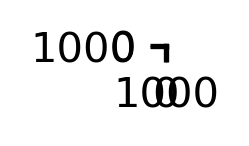

In [10]:
# reading in images and samples

# read in all image file names from the folder
files = [f for f in listdir(dataPath) if isfile(join(dataPath, f)) if ".DS_Store" not in f if ".tif" in f]
files = sorted(files)
nimg = len(files)
print(nimg)

### Reading in the samples
imgs = [skimage.io.imread(f) for f in files]
plot_number = 1 ##plot num for number of images you want to see
if nimg < plot_number:
    plot_number = nimg
plt.figure(figsize=(1,1))
for k,img in enumerate(imgs[:plot_number]):
    plt.subplot(110,plot_number,k+1)
    plt.imshow(img)

In [11]:
# Running cellpose model

# DEFINE CELLPOSE MODEL
# model_type='cyto', 'cyto2' or model_type='nuclei'

model = models.CellposeModel(gpu=True, pretrained_model= segmentation_model)

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0 -> channels = [0,0]

# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE Green=cytoplasm and Blue=nucleus
# channels = [2,1] # IF YOU HAVE Green=cytoplasm and Red=nucleus

channels = [0,0]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images

diameterParam = model.diam_labels

# flow threshold: Sometimes the neural network identifies cell shapes, which are in reality no cell shape.
# default is 0.4
# If you have too many masks in the image because the image is too noisy, decrease this parameter slightly.
# Increase this parameter if cellpose is not returning as many region of interest as you’d expect. (For example different cell sizes)

flowThreshold = 0.4

#cellprob_threshold: Each shape gets a probability of being a cell
#Decrease this threshold if cellpose is not returning as many ROIs as you’d expect.
#Similarly, increase this threshold if cellpose is returning too ROIs particularly from dim areas.

cellprobThreshold = 0.0

#model = models.CellposeModel(gpu=use_GPU, model_type=modelType)
masks, flows, styles = model.eval(imgs, diameter=diameterParam, flow_threshold=flowThreshold, channels=channels, cellprob_threshold=cellprobThreshold)

2024-08-07 11:15:22,018 [INFO] >>>> loading model /Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/scripts/nucleiDysmorphia/dysmorphicNucleiCellposeModel
2024-08-07 11:15:22,032 [INFO] TORCH CUDA version not installed/working.
2024-08-07 11:15:22,033 [INFO] >>>> using CPU
2024-08-07 11:15:22,034 [INFO] WARNING: MKL version on torch not working/installed - CPU version will be slightly slower.
2024-08-07 11:15:22,034 [INFO] see https://pytorch.org/docs/stable/backends.html?highlight=mkl
2024-08-07 11:15:22,468 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2024-08-07 11:15:22,469 [INFO] >>>> model diam_labels =  109.242 (mean diameter of training ROIs)
2024-08-07 11:22:04,037 [INFO] 100%|##########| 68/68 [06:41<00:00,  5.91s/it]


In [12]:
## save output to *_seg.npy

from cellpose import io
os.chdir(segPath)
'''io.masks_flows_to_seg(imgs,
                      masks,
                      flows,
                      diameterParam*np.ones(len(masks)),
                      files,
                      [0, 0])'''

io.save_masks(imgs,
              masks,
              flows,
              files,
              #channels=[0, 0],
              #png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              #save_txt=False, # save txt outlines for ImageJ
              #save_flows=False, # save flows as TIFFs
              #save_outlines=True, # save outlines as TIFFs
              )

In [7]:
# function to identify nuclei on the periphery of the image and remove them

def remove_peripherals(input_dir, output_dir):
    # List all .tif files in the input directory
    all_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

    for filename in all_files:
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Load the image
        image = imread(input_image_path)

        # Identify the unique labels (or nuclear masks) in the image, excluding the background
        labels = np.unique(image)[1:]

        # Check the boundaries
        boundaries = [
            image[0, :],           # Top row
            image[:, 0],           # Leftmost column
            image[-1, :],          # Bottom row
            image[:, -1],          # Rightmost column
        ]

        # List to store labels that touch the boundary
        labels_to_remove = []

        for label in labels:
            for boundary in boundaries:
                if label in boundary:
                    labels_to_remove.append(label)
                    break

        # For each label that touches the boundary, set its value to 0
        for label_value in labels_to_remove:
            image[image == label_value] = 0

        # Save the modified image to the output directory
        imwrite(output_image_path, image)


In [13]:
### getting rid of nuclei that are cut-off by the periphery of the image
remove_peripherals(segPath, qcPath)

The following 2 cells are optional. They should be executed only if you plan on visualizing the nucleli feature UMAP using the shiny app.

In [16]:
### function to make separate images for each nucleus in an image (for the visualization in the shiny app)

def make_individuals(folder_path, save_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".tif"):
            full_path = os.path.join(folder_path, filename)
            image = Image.open(full_path)

            # Iterate over the segmented cells in the image
            for cell_number in set(image.getdata()):
                if cell_number != 0:  # Exclude the background pixels labeled as 0
                    # Generate the filename for this cell
                    cell_filename = filename.replace(".tif", f"_{cell_number}.png")
                    cell_full_path = os.path.join(save_path, cell_filename)
                    
                    # Check if the file already exists
                    if not os.path.exists(cell_full_path):
                        # Find the bounding box of the cell
                        cell_pixels = [(x, y) for x in range(image.width) for y in range(image.height) if image.getpixel((x, y)) == cell_number]
                        min_x = min(cell_pixels, key=lambda p: p[0])[0]
                        min_y = min(cell_pixels, key=lambda p: p[1])[1]
                        max_x = max(cell_pixels, key=lambda p: p[0])[0]
                        max_y = max(cell_pixels, key=lambda p: p[1])[1]
                        cell_box = (min_x, min_y, max_x, max_y)
                        cell_image = image.crop(cell_box)  # Crop the image to the cell bounding box

                        # Create a new binary image of the cell size
                        cell_binary = Image.new("1", cell_image.size, color=0)

                        # Iterate over the pixels in the cropped cell image and update the binary image
                        for x in range(cell_image.width):
                            for y in range(cell_image.height):
                                if cell_image.getpixel((x, y)) == cell_number:
                                    cell_binary.putpixel((x, y), 1)

                        # Save the binary image
                        cell_binary.save(cell_full_path)
                    else:
                        print(f"Skipping {cell_filename} as it already exists.")

In [19]:
qcPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/12wk/filtered/"
individualsPath = "/Volumes/fsmresfiles/Basic_Sciences/CDB/CDB_Collaborations/Arispe_Goyal/MadelineMelzer/DATA/nucleiDysmorphia/data/age/individuals/"
make_individuals(qcPath, individualsPath)


Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_5.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_6.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_7.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_8.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_9.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_11.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_13.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_15.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_16.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_17.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_20.png as it already exists.
Skipping MaxIP_12wk_Male1_568LaminA_Arch_60x_2_cp_masks_21.png as it a